In [ ]:
import import_ipynb
import utils
import numpy as np


In [ ]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")

X_list = []

for annee in range(11, 19):
        
    data_pop_slice = data_pop[annee].iloc[:, :]
    data_fertility_slice = data_fertility[annee].iloc[:, 1:]
    data_child_slice = data_child[annee].iloc[:, 1:]
    data_capita_slice = data_capita[annee].iloc[:, 1:]

    concatenated_data = np.concatenate((
        data_pop_slice, 
        data_fertility_slice, 
        data_child_slice, 
        data_capita_slice
    ), axis=1)

    X_list.append(concatenated_data)

X = np.vstack(X_list)

In [ ]:
#preparation des labels pour classification 1992-->2020
import pandas as pd

label_class = pd.read_csv("labels_class.csv")
label_class.head()

labels_list = []
for i in range(len(label_class)):
    label = label_class.iloc[i, :-1]
    labels_list.append(label)

y_class = pd.concat(labels_list, axis=0, ignore_index=True)

In [10]:
# création des label pour tous les événements 1992->2020
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")

labels_list = []
for i in range(len(df_delegations)):
    label = df_delegations.iloc[i, :-1]
    labels_list.append(label)

y = pd.concat(labels_list, axis=0, ignore_index=True)


In [11]:
y.shape

In [12]:
X.shape

In [28]:
X[:, 0]

country_names = X[:, 0]

X = X[:, 1:]
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32) 
y_class = np.array(y_class, dtype=np.float32)

X_train, X_test, y_train, y_test, country_train, country_test, cl_train, cl_test = train_test_split(
    X, y, country_names, y_class,  test_size=0.2, random_state=42)


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

country_names = X[:, 0]

X = X[:, 1:]
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32) 

X_train, X_test, y_train, y_test, country_train, country_test = train_test_split(
    X, y, country_names, test_size=0.2, random_state=42)

inputs = Input(shape=(X_train.shape[1],))

x = Dense(50, activation='relu')(inputs)
#x = Dropout(0.3)(x)

#x = Dense(16, activation='relu')(x)
#x = Dropout(0.3)(x)

x = Dense(12, activation='relu')(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)


In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Input layer
inputs = Input(shape=(X_train.shape[1],))

# Shared base layers
x = Dense(16, activation='relu')(inputs)
# Optional: Dropout layer to prevent overfitting
# x = Dropout(0.3)(x)

# Output layers for both tasks: regression and classification
output_reg = Dense(1, activation='relu', name='regression_output')(x)  # Regression output
output_clf = Dense(1, activation='sigmoid', name='classification_output')(x)  # Classification output

# Define the model
model = Model(inputs=inputs, outputs=[output_reg, output_clf])

# Compile the model
model.compile(
    optimizer='adam',
    loss={'regression_output': 'mean_squared_error', 'classification_output': 'binary_crossentropy'},
    metrics={'regression_output': 'mae', 'classification_output': 'accuracy'}
)

# Train the model
history = model.fit(
    X_train,
    {'regression_output': y_train, 'classification_output': cl_train},
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - classification_output_accuracy: 0.5483 - classification_output_loss: 0.1531 - loss: 1.1034 - regression_output_loss: 0.9480 - regression_output_mae: 0.3877 - val_classification_output_accuracy: 0.7464 - val_classification_output_loss: 0.1613 - val_loss: 0.6026 - val_regression_output_loss: 0.4160 - val_regression_output_mae: 0.4143
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - classification_output_accuracy: 0.6702 - classification_output_loss: 0.1537 - loss: 0.7634 - regression_output_loss: 0.6088 - regression_output_mae: 0.3792 - val_classification_output_accuracy: 0.8134 - val_classification_output_loss: 0.1599 - val_loss: 0.5780 - val_regression_output_loss: 0.3958 - val_regression_output_mae: 0.4079
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - classification_output_accuracy: 0.7630 - classification_output_loss: 0.1501 - loss: 0.6913 - regression_output_loss: 0.5400 - regression_output_mae: 0.3625 - val_classificat

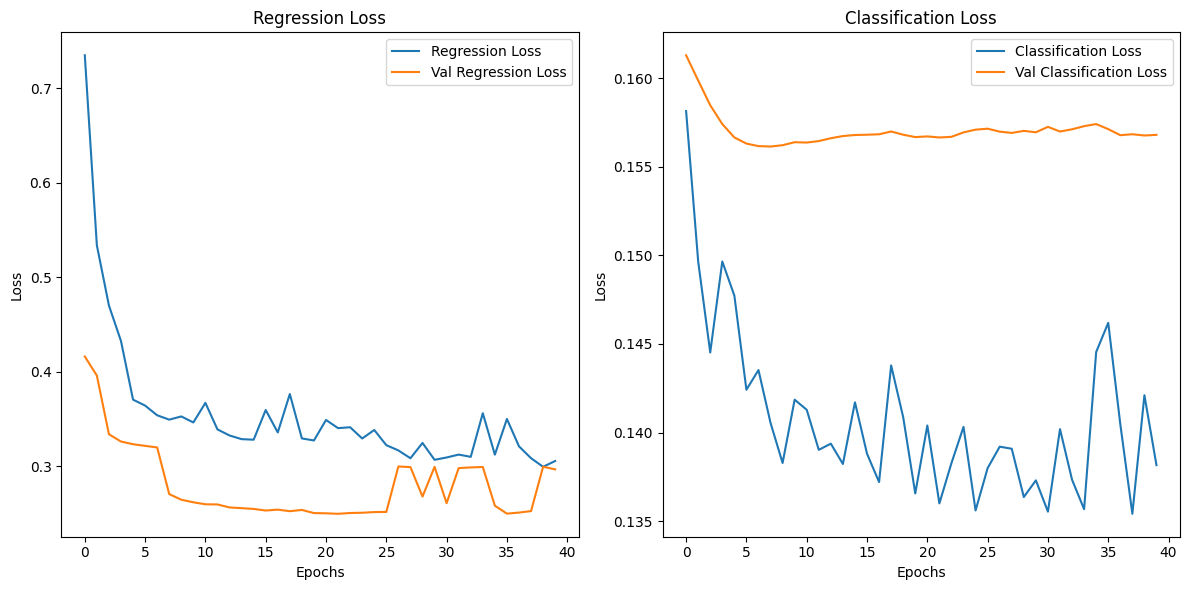

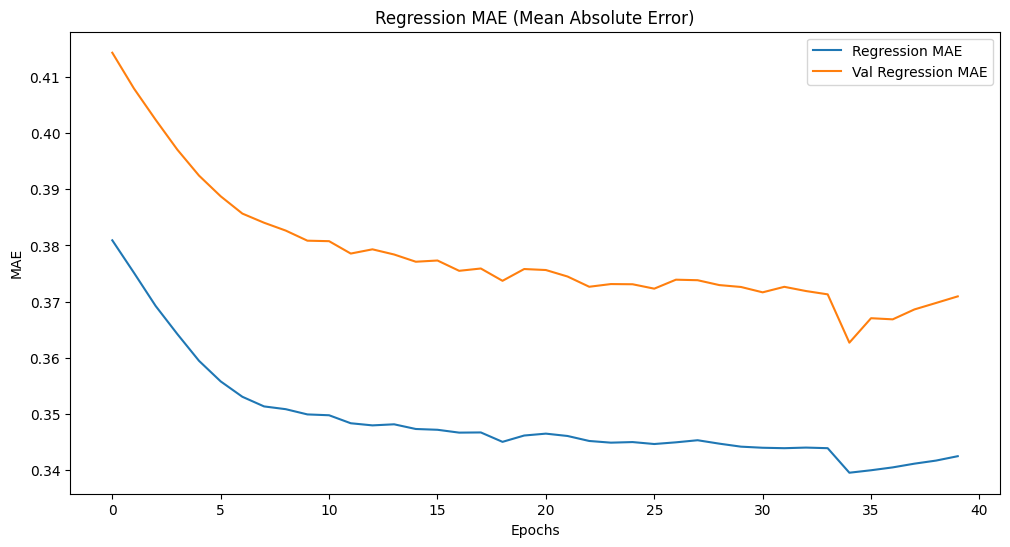

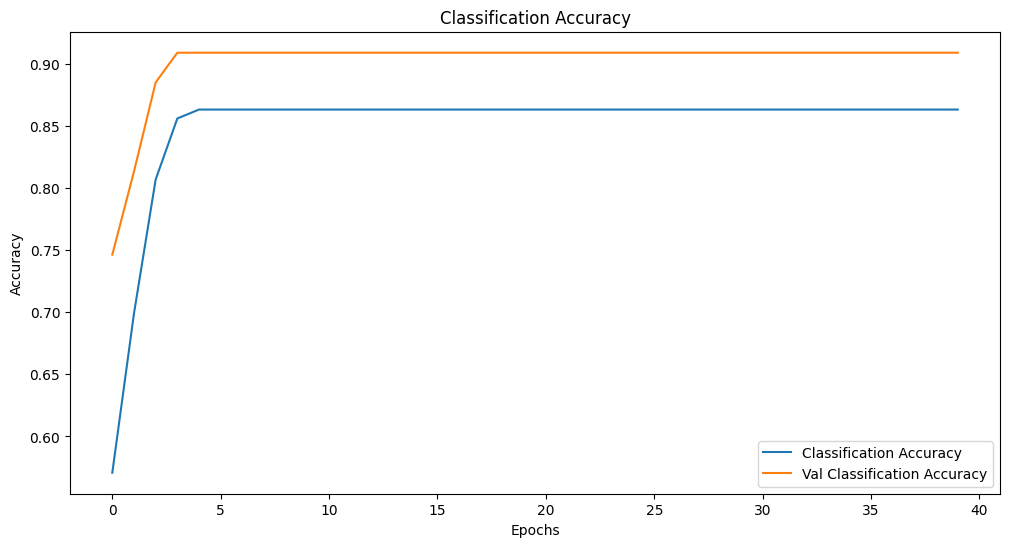

In [39]:
import matplotlib.pyplot as plt

# Assuming history contains the training logs from model.fit()

# Plot loss for both tasks (regression and classification)
plt.figure(figsize=(12, 6))

# Plot Regression Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['regression_output_loss'], label='Regression Loss')
plt.plot(history.history['val_regression_output_loss'], label='Val Regression Loss')
plt.title('Regression Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Classification Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_loss'], label='Classification Loss')
plt.plot(history.history['val_classification_output_loss'], label='Val Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot MAE for Regression (Mean Absolute Error)
plt.figure(figsize=(12, 6))
plt.plot(history.history['regression_output_mae'], label='Regression MAE')
plt.plot(history.history['val_regression_output_mae'], label='Val Regression MAE')
plt.title('Regression MAE (Mean Absolute Error)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plot Accuracy for Classification
plt.figure(figsize=(12, 6))
plt.plot(history.history['classification_output_accuracy'], label='Classification Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Val Classification Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
import matplotlib.pyplot as plt

# Plot Regression Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['regression_output_loss'], label='Regression Loss')
plt.plot(history.history['val_regression_output_loss'], label='Val Regression Loss')
plt.title('Regression Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("regression_loss.png")  # Save the Regression Loss plot
plt.close()  # Close the plot to avoid overlap in future plots

# Plot Classification Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['classification_output_loss'], label='Classification Loss')
plt.plot(history.history['val_classification_output_loss'], label='Val Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("classification_loss.png")  # Save the Classification Loss plot
plt.close()

# Plot MAE for Regression (Mean Absolute Error)
plt.figure(figsize=(12, 6))
plt.plot(history.history['regression_output_mae'], label='Regression MAE')
plt.plot(history.history['val_regression_output_mae'], label='Val Regression MAE')
plt.title('Regression MAE (Mean Absolute Error)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.savefig("regression_mae.png")  # Save the Regression MAE plot
plt.close()

# Plot Accuracy for Classification
plt.figure(figsize=(12, 6))
plt.plot(history.history['classification_output_accuracy'], label='Classification Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Val Classification Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("classification_accuracy.png")  # Save the Classification Accuracy plot
plt.close()


In [12]:
X.shape

(1304, 5)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout


inputs = Input(shape=(X_train.shape[1],))

x = Dense(50, activation='relu')(inputs)
#x = Dropout(0.3)(x)

#x = Dense(16, activation='relu')(x)
#x = Dropout(0.3)(x)

x = Dense(12, activation='relu')(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2697 - mae: 0.3893 - val_loss: 0.2053 - val_mae: 0.3758
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1719 - mae: 0.3472 - val_loss: 0.1671 - val_mae: 0.3608
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1581 - mae: 0.3511 - val_loss: 0.1629 - val_mae: 0.3549
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1479 - mae: 0.3368 - val_loss: 0.1598 - val_mae: 0.3521
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1515 - mae: 0.3430 - val_loss: 0.1590 - val_mae: 0.3517
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1421 - mae: 0.3284 - val_loss: 0.1582 - val_mae: 0.3501
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1443 - mae: 0.3342 - val_loss: 0.1570 - val_mae: 0.3489
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1428 - mae: 0.3320 - val_loss: 0.1565 - val_mae: 0.3491
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1389 - m

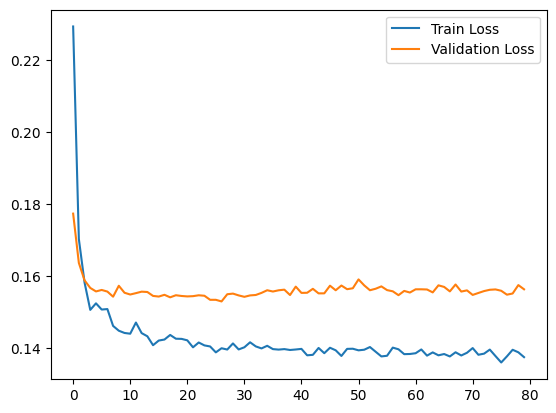

In [ ]:
# plot de history pour voir l'évolution de la loss et de la mae
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# calcul de la mse
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Absolute Error: 0.3310295343399048
Mean Squared Error: 0.142070472240448
